In [47]:

import os
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError, MeanAbsolutePercentageError
from sktime.forecasting.compose import ColumnEnsembleForecaster

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

from sktime.split import SlidingWindowSplitter
from sktime.utils.plotting import plot_windows
from sktime.forecasting.base import ForecastingHorizon

from oceanwave_forecast import data_manager, data_pipeline, forecasting_utils

import os
import importlib
import joblib
importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(forecasting_utils)

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA, AutoARIMA

from sktime.forecasting.model_evaluation import evaluate


from sktime.split import temporal_train_test_split
from sktime.transformations.compose import ColumnEnsembleTransformer

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

# PREPARING DATA

In [ ]:
# Define the paths to the three .txt files
folder1_txt = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\Standard meteorological data 2024\\46088h2024.txt'
output_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\benchmarks'
pipeline_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\pipelines'

data_ocean_raw = data_manager.extract_raw_data(folder1_txt)
data_ocean_raw.info()
processed_data = data_pipeline.preprocess_ocean_data(data_ocean_raw)

# NOTE Truncate the processed data to only include the first 6 months (from Jan 1st to Jun 30th, 2024)
processed_data = processed_data.loc['2024-01-01':'2024-03-30']


processed_data.info()

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


In [49]:
processed_data_Y = processed_data[['WVHT', 'APD']].copy()
processed_data_X = processed_data.drop(columns=['WVHT', 'APD'])

one_day = 24
one_week = one_day * 7
horizon_steps = one_day*3 # 3 days prediction horizon
training_window = one_week*3  # 3 weeks of training data
fh = ForecastingHorizon(list(range(1, horizon_steps + 1)), is_relative=True)

y_train, y_test, X_train, X_test = temporal_train_test_split(y=processed_data_Y, X=processed_data_X, test_size=horizon_steps*3)


In [51]:

pipe_X, pipe_Y = data_pipeline.get_pipelines(list(X_train.columns))

X_train_transformed = pipe_X.fit_transform(X_train)
X_test_transformed  = pipe_X.transform(X_test)
Y_train_transformed = pipe_Y.fit_transform(y_train)
Y_test_transformed  = pipe_Y.transform(y_test)


# NAIVE FORECASTER

In [52]:

    # Define the forecaster 
forecasters_list = [
    ("naive1", NaiveForecaster(strategy='last'), 0),
    ("naive2", NaiveForecaster(strategy='mean'), 1),]

forecaster = ColumnEnsembleForecaster(forecasters=forecasters_list)
forecaster.fit(
    y               = Y_train_transformed,
    X               = X_train_transformed,  
    fh              = fh
)


ColumnEnsembleForecaster(forecasters=[('naive1', NaiveForecaster(), 0),
                                      ('naive2',
                                       NaiveForecaster(strategy='mean'), 1)])

In [53]:
    # Define metrics
scorers = [
        MeanSquaredPercentageError(),
        MeanAbsolutePercentageError()
    ]



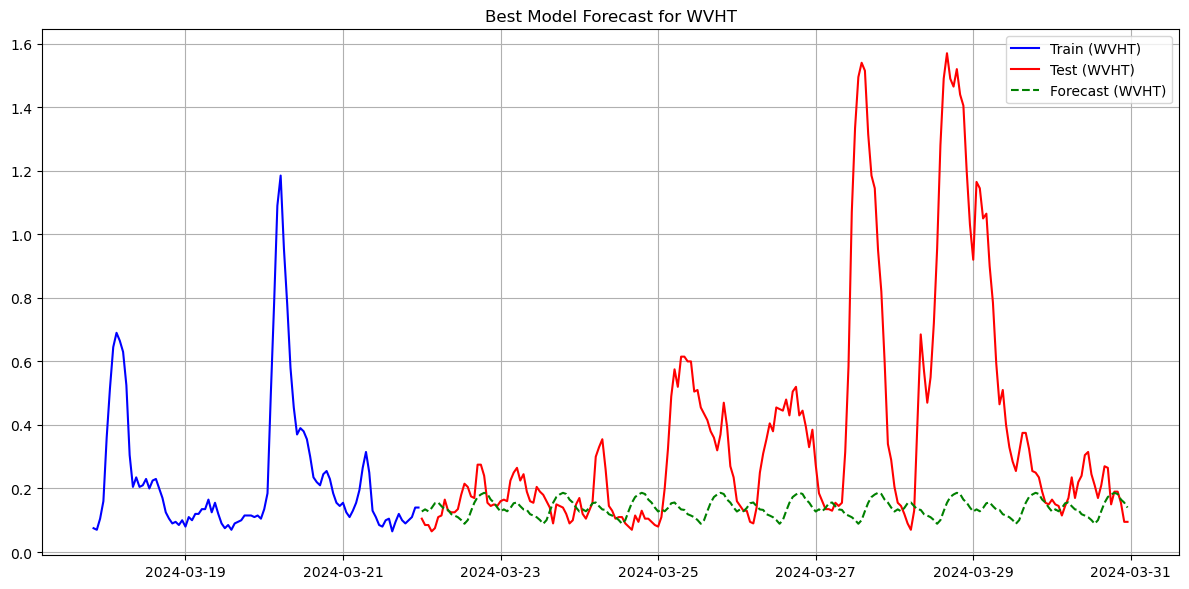

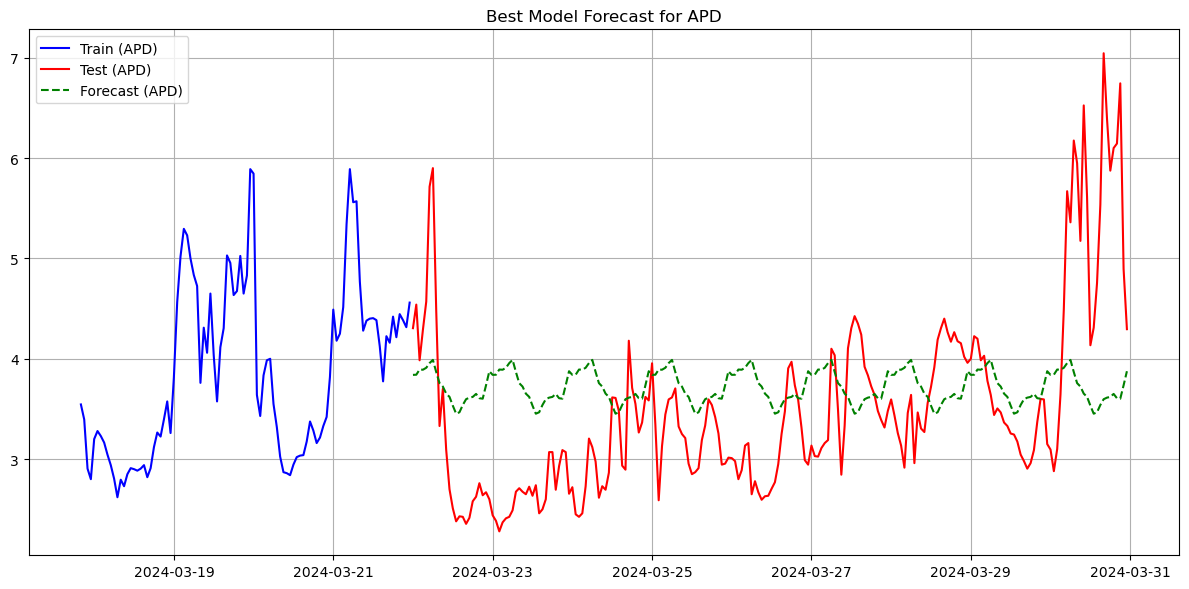

MeanSquaredPercentageError → 0.2050
MeanAbsolutePercentageError → 0.3618


In [54]:
# Test Dataset plot comparison
y_pred = forecaster.predict(ForecastingHorizon(y_test.index, is_relative=False))
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_train[target][-100:], label=f'Train ({target})', color='blue')
            plt.plot(y_test[target], label=f'Test ({target})', color='red')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='green', linestyle='--')
            
            plt.title(f'Best Model Forecast for {target}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_test, y_pred)
    print(f"{name} → {value:.4f}")

# AUTOARIMA

In [61]:
common_kwargs = dict(
    sp=24,                # seasonal period = 24 hours
    start_p=1,            # starting AR order
    start_q=1,            # starting MA order
    max_p=3,              # max AR order
    max_q=2,              # max MA order
    max_d = 1,           # max differencing order
    max_D = 1,           # max seasonal differencing order
    max_P=1,          # max seasonal AR order
    max_Q=1,          # max seasonal MA order
    seasonal=True,        # seasonal ARIMA
    information_criterion="aic",
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    n_jobs=-1,
)

    # Define the forecaster 
forecasters_list = [
    ("ARIMA1", AutoARIMA(**common_kwargs), 0),
    ("ARIMA2", AutoARIMA(**common_kwargs), 1),
]

forecaster = ColumnEnsembleForecaster(forecasters=forecasters_list)
forecaster.fit(
    y               = Y_train_transformed,
    X               = X_train_transformed,  
    fh              = fh
)




ColumnEnsembleForecaster(forecasters=[('ARIMA1',
                                       AutoARIMA(error_action='ignore', max_P=1,
                                                 max_Q=1, max_d=1, max_p=3,
                                                 max_q=2, n_jobs=-1, sp=24,
                                                 start_p=1, start_q=1,
                                                 suppress_warnings=True),
                                       0),
                                      ('ARIMA2',
                                       AutoARIMA(error_action='ignore', max_P=1,
                                                 max_Q=1, max_d=1, max_p=3,
                                                 max_q=2, n_jobs=-1, sp=24,
                                                 start_p=1, start_q=1,
                                                 suppress_warnings=True),
                                       1)])

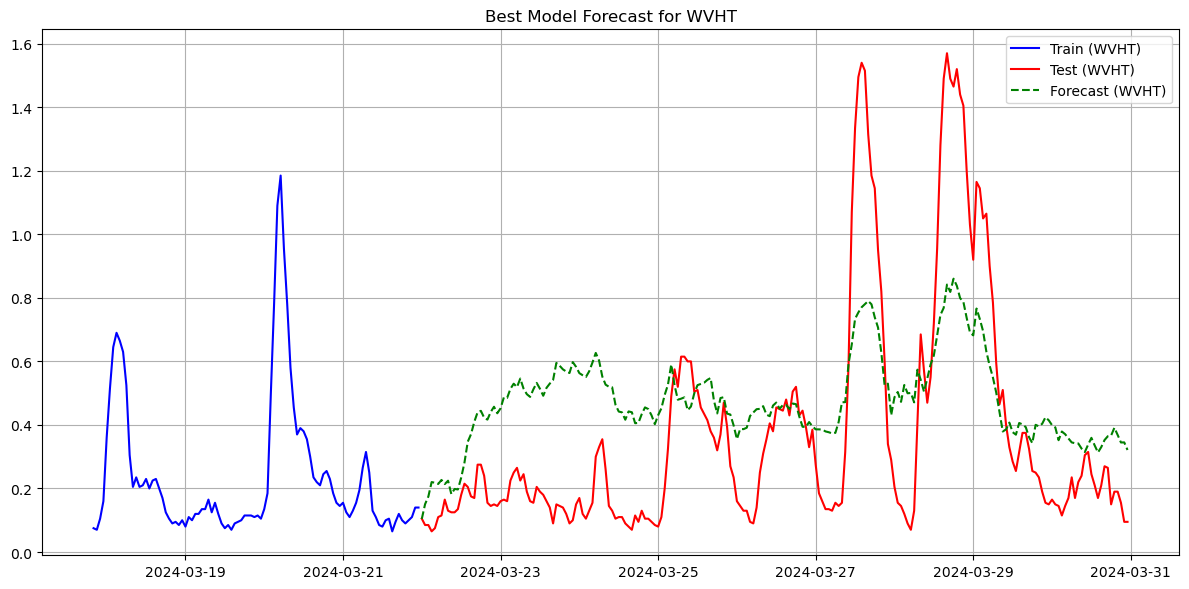

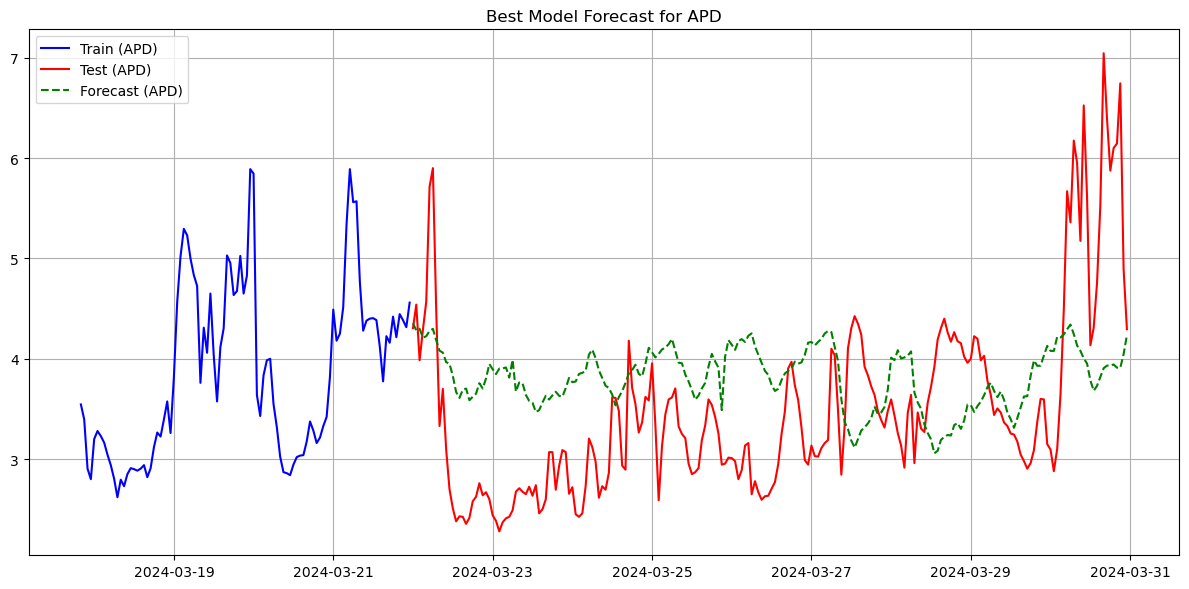

MeanSquaredPercentageError → 1.6514
MeanAbsolutePercentageError → 0.7517


In [62]:
# Test Dataset plot comparison
y_pred = forecaster.predict(ForecastingHorizon(y_test.index, is_relative=False), X = X_test_transformed)
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_train[target][-100:], label=f'Train ({target})', color='blue')
            plt.plot(y_test[target], label=f'Test ({target})', color='red')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='green', linestyle='--')
            
            plt.title(f'Best Model Forecast for {target}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_test, y_pred)
    print(f"{name} → {value:.4f}")

# SARIMA

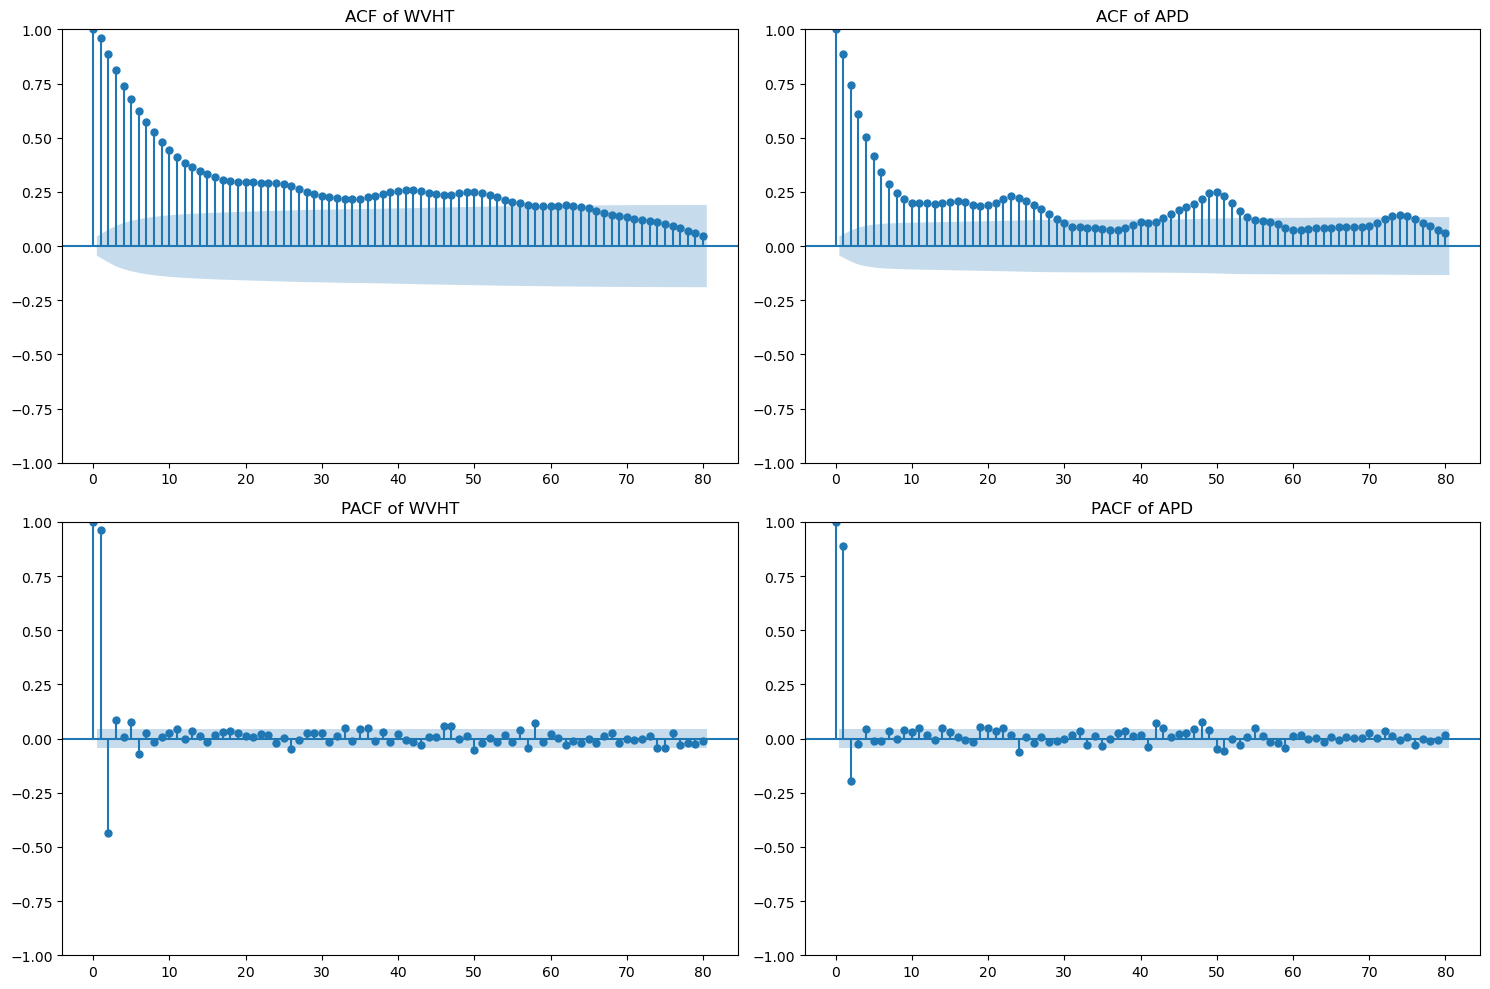

In [55]:

# Plotting ACF and PACF for the transformed training data

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: ACF plots
for i, col in enumerate(Y_train_transformed.columns):
    plot_acf(Y_train_transformed[col], lags=80, ax=axes[0, i])
    axes[0, i].set_title(f"ACF of {col}")

# Second row: PACF plots (imported here if not already available)
for i, col in enumerate(Y_train_transformed.columns):
    plot_pacf(Y_train_transformed[col], lags=80, ax=axes[1, i])
    axes[1, i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()

In [1]:
# Notes:
# We see a downward trend in ACF: A non-seasonal AR(1)
# We need peaks of 12, 24, 36, 48, 60, 72, 84: A seasonal MA(1) 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: ACF plots
for i, col in enumerate(Y_train_transformed.columns):
    series =Y_train_transformed[col]
    series = series.diff(24).dropna()
    plot_acf(series, lags=80, ax=axes[0, i])
    axes[0, i].set_title(f"ACF2 of {col}")

# Second row: PACF plots (imported here if not already available)
for i, col in enumerate(Y_train_transformed.columns):
    series =Y_train_transformed[col]
    series = series.diff(24).dropna()
    plot_pacf(series, lags=80, ax=axes[1, i])
    axes[1, i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

(1944, 10)

In [58]:
from sktime.forecasting.sarimax import SARIMAX

forecasters_list = [
    ("SARIMA1",SARIMAX( order=(1, 0, 0), seasonal_order=(0, 1, 1, 24))  , 0),
    ("SARIMA2", SARIMAX( order=(1, 0, 0), seasonal_order=(0, 1, 1, 24))  , 1),
]



forecaster = ColumnEnsembleForecaster(forecasters=forecasters_list)
forecaster.fit(
    y               = Y_train_transformed,
    X               = X_train_transformed,  
    fh              = fh
)



ColumnEnsembleForecaster(forecasters=[('SARIMA1',
                                       SARIMAX(seasonal_order=(0, 1, 1, 24)),
                                       0),
                                      ('SARIMA2',
                                       SARIMAX(seasonal_order=(0, 1, 1, 24)),
                                       1)])

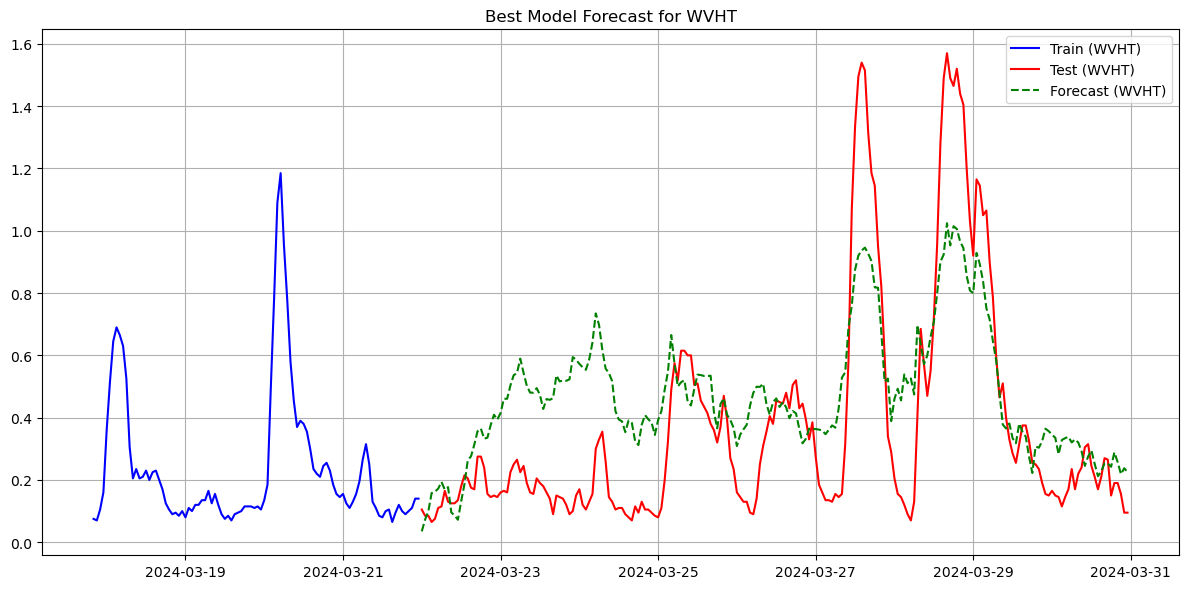

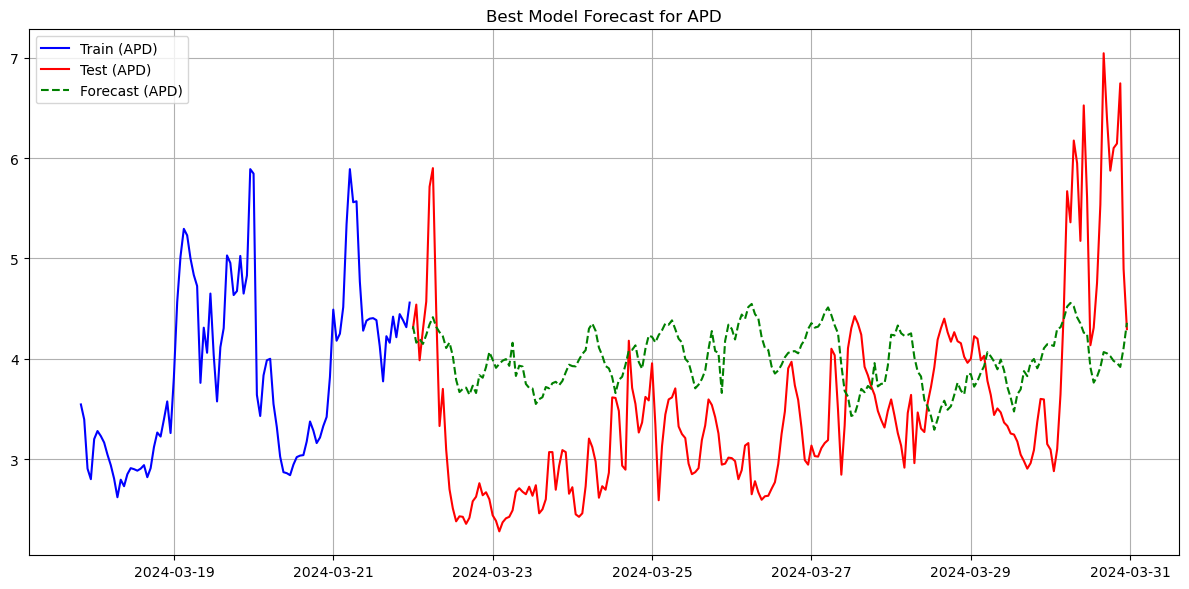

MeanSquaredPercentageError → 1.3927
MeanAbsolutePercentageError → 0.6847


In [60]:
# Test Dataset plot comparison
y_pred = forecaster.predict(fh = ForecastingHorizon(y_test.index, is_relative=False), X = X_test_transformed)
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_train[target][-100:], label=f'Train ({target})', color='blue')
            plt.plot(y_test[target], label=f'Test ({target})', color='red')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='green', linestyle='--')
            
            plt.title(f'Best Model Forecast for {target}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_test, y_pred)
    print(f"{name} → {value:.4f}")